## Data

In [169]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [171]:
# multiple txt files --> one df
from data.data_processing import list_epitopes, load_epitope_trb_data

train_folder = '../data/training_data/'
epitopes = list_epitopes(train_folder)

dfs = []
for epitope in epitopes:
    df = load_epitope_trb_data(train_folder, epitope)
    df['Epitope'] = epitope
    df = df[['Epitope', 'TRB_CDR3', 'Label']]
    dfs.append(df)

df = pd.concat(dfs)
df.head(10)

,Epitope,TRB_CDR3,Label
0,ATDALMTGF,CASRGDTFYEQYF,1
1,ATDALMTGF,CATSDSVAGNQPQHF,1
2,ATDALMTGF,CAISESSSGNNEQFF,1
3,ATDALMTGF,CASSFGGSRLGEETQYF,1
4,ATDALMTGF,CASSPLTGESMSEKLFF,1
5,ATDALMTGF,CAISESSAGFNEQFF,1
6,ATDALMTGF,CSARDTVSSNQPQHF,1
7,ATDALMTGF,CASSYPRTASNQPQHF,1
8,ATDALMTGF,CASSQFFSGEGLYGYTF,1
9,ATDALMTGF,CASSENSNSNQPQHF,1


In [172]:
# find the maximum sequence lengths in both train and test set

from data.data_processing import max_trb_epitope_lengths

max_len_trb, max_len_epitope = max_trb_epitope_lengths(train_folder, '../data/true_set/')
input_shape = max_len_trb, max_len_epitope, 4
print(input_shape)

(21, 10, 4)


In [173]:
from external.bio.peptide_feature import parse_features, parse_operator
from external.bio.feature_builder import CombinedPeptideFeatureBuilder

# specify the different interaction map features and the operator that is used to calculate the entries
features_list = parse_features('hydrophob,isoelectric,mass,hydrophil')
operator = parse_operator('absdiff')
feature_builder = CombinedPeptideFeatureBuilder(features_list, operator)

In [174]:
# for each tcr-epitope pair, generate an interaction map, zero pad it and store it in df
from data.data_processing import generate_interaction_map, pad

df['interaction_map'] = df.apply(
    lambda row: pad(
        generate_interaction_map(
            row['TRB_CDR3'],
            row['Epitope'],
            'hydrophob,isoelectric,mass,hydrophil',
            'absdiff'
        ), 
        max_len_trb,
        max_len_epitope
    ), 
    axis=1
)
df = df[['interaction_map', 'Label']]

In [175]:
print(df.iloc[0,0].shape)

(21, 10, 4)


## Model

In [176]:
from models.CNN_model.model import build_model

model = build_model(input_shape)

model.compile(
    optimizer='rmsprop',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve="ROC", name="roc_auc"), 
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ],
    loss_weights=None,
    sample_weight_mode=None,
    weighted_metrics=None,
    target_tensors=None,
    distribute=None,
)

## Train

In [177]:
# split data into train and validation set
from sklearn.model_selection import train_test_split

X = list(df['interaction_map'])
y = list(df['Label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [178]:
# convert data to tf.data.Dataset objects and batch
train_data = tf.data.Dataset.from_tensor_slices((np.array(X_train), np.array(y_train)))
val_data = tf.data.Dataset.from_tensor_slices((np.array(X_val), np.array(y_val)))

train_data = train_data.shuffle(buffer_size=len(train_data), seed=42, reshuffle_each_iteration=True).batch(32)
val_data = val_data.batch(32)

In [179]:
history = model.fit(
    x=train_data,
    epochs=30,
    validation_data=val_data,
    class_weight=None,
    max_queue_size=2,
    use_multiprocessing=True,
    verbose=1,
    shuffle=False,
)

Epoch 1/30
368/368 [==============================] - 26s 66ms/step - loss: 2.8926 - accuracy: 0.8319 - roc_auc: 0.5849 - precision: 0.5080 - recall: 0.0480 - val_loss: 0.7558 - val_accuracy: 0.8419 - val_roc_auc: 0.5445 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
368/368 [==============================] - 24s 65ms/step - loss: 0.5839 - accuracy: 0.8426 - roc_auc: 0.6314 - precision: 0.7186 - recall: 0.1071 - val_loss: 0.5657 - val_accuracy: 0.8524 - val_roc_auc: 0.6825 - val_precision: 1.0000 - val_recall: 0.0667
Epoch 3/30
368/368 [==============================] - 24s 64ms/step - loss: 0.5189 - accuracy: 0.8465 - roc_auc: 0.6651 - precision: 0.7358 - recall: 0.1379 - val_loss: 0.5198 - val_accuracy: 0.8422 - val_roc_auc: 0.6333 - val_precision: 1.0000 - val_recall: 0.0022
Epoch 4/30
368/368 [==============================] - 24s 64ms/step - loss: 0.5080 - accuracy: 0.8488 - roc_auc: 0.6672 - precision: 0.7775 - recall: 0.1429 - val_loss: 0.4813 - val_accuracy: 0.

In [180]:
model.save('../models/binary_classification_30')

INFO:tensorflow:Assets written to: ../models/binary_classification_30\assets


INFO:tensorflow:Assets written to: ../models/binary_classification_30\assets


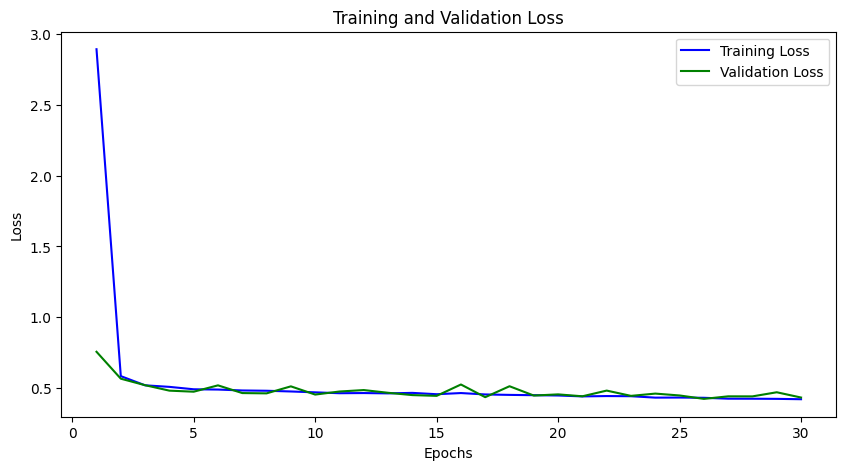

In [181]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['loss'], color='blue', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], color='green', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

C:\Users\moham\AppData\Local\Temp\ipykernel_9232\2914632935.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['accuracy'], 'b', label='Accuracy', color='blue')
C:\Users\moham\AppData\Local\Temp\ipykernel_9232\2914632935.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy', color='cyan', linestyle='dashed')
C:\Users\moham\AppData\Local\Temp\ipykernel_9232\2914632935.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['roc_auc'], 'b', label='ROC AUC', color='red')
C

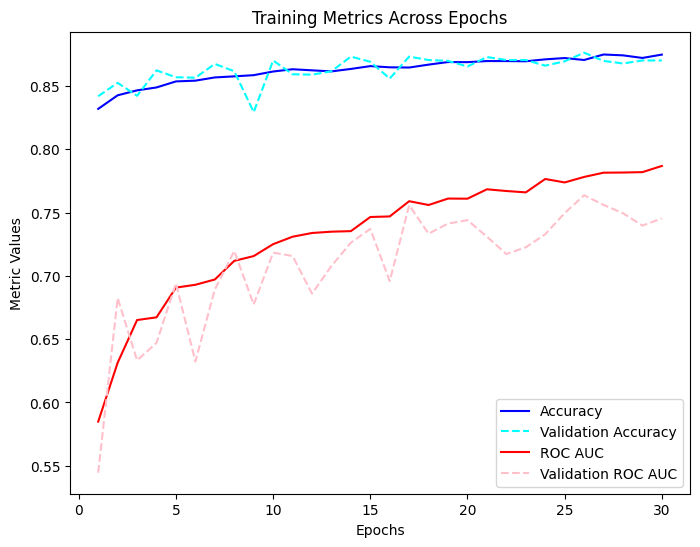

In [182]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['accuracy'], 'b', label='Accuracy', color='blue')
if 'val_accuracy' in history.history:
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy', color='cyan', linestyle='dashed')


plt.plot(epochs, history.history['roc_auc'], 'b', label='ROC AUC', color='red')
if 'val_roc_auc' in history.history:
    plt.plot(epochs, history.history['val_roc_auc'], 'b', label='Validation ROC AUC', color='pink', linestyle='dashed')

plt.title('Training Metrics Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric Values')

plt.legend()

plt.show()


## Test

In [183]:
test_folder = '../data/true_set/'
test_epitopes = list_epitopes(test_folder)

In [189]:
loaded_model = tf.keras.models.load_model('../models/binary_classification_30')

In [190]:
from sklearn.metrics import roc_auc_score
auc_scores = dict()
for test_epitope in test_epitopes:
    df = load_epitope_trb_data(test_folder, test_epitope)
    df['interaction_map'] = df.apply(
        lambda row: pad(
            generate_interaction_map(
                row['TRB_CDR3'],
                test_epitope,
                'hydrophob,isoelectric,mass,hydrophil',
                'absdiff'
            ), 
            max_len_trb,
            max_len_epitope
        ), 
        axis=1
    )
    df = df[['interaction_map', 'Label']]
    
    imaps = list(df['interaction_map'])
    imaps_tensor = tf.stack(imaps)
    true_labels  = list(df['Label'])
    predicted_scores = loaded_model.predict(imaps_tensor)
    auc = roc_auc_score(true_labels, predicted_scores)
    auc_scores[test_epitope] = auc

13/13 [==============================] - 0s 19ms/step


In [191]:
auc_scores

{'ATDALMTGF': 0.7740011926058437,
 'CINGVCWTV': 0.6648946269223467,
 'GILGFVFTL': 0.882249608423251,
 'GLCTLVAML': 0.8347363757199823,
 'GPRLGVRAT': 0.5472370766488414,
 'HPVTKYIM': 0.7277777777777777,
 'KSKRTPMGF': 0.64910790144435,
 'LLWNGPMAV': 0.8136713444997735,
 'LTDEMIAQY': 0.5775999999999999,
 'NLVPMVATV': 0.5969997457411644,
 'NQKLIANQF': 0.5868544600938967,
 'NYNYLYRLF': 0.9880952380952381,
 'RAQAPPPSW': 0.9604938271604939,
 'SPRWYFYYL': 0.6160201149425287,
 'TPRVTGGGAM': 0.7543859649122807,
 'TTDPSFLGRY': 0.6094619666048238,
 'YLQPRTFLL': 0.7981028591979861}

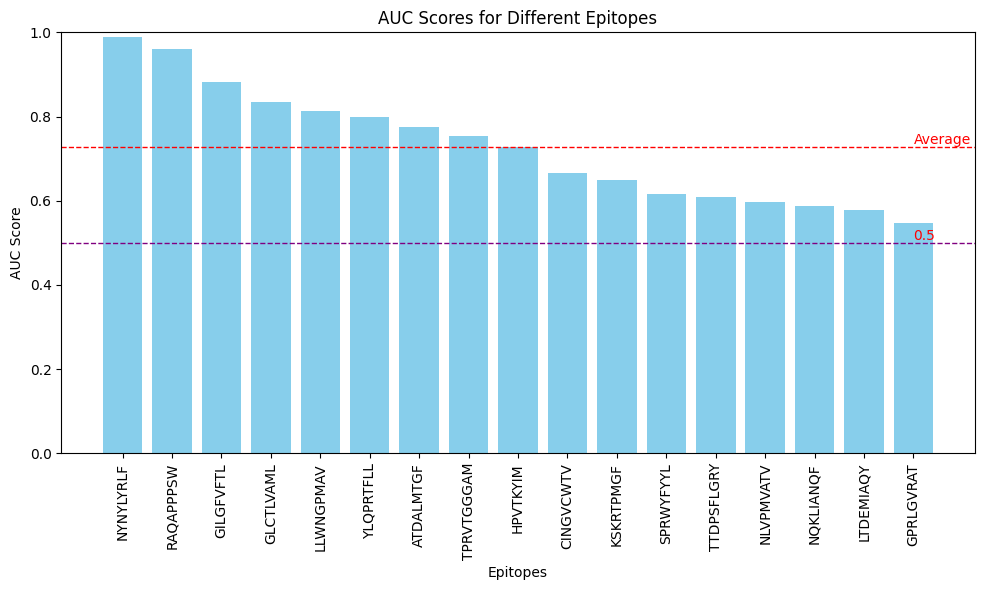

In [192]:
auc_scores = dict(sorted(auc_scores.items(), key=lambda item: item[1], reverse=True))
average_auc_score = sum(auc_scores.values()) / len(auc_scores)
plt.figure(figsize=(10, 6))
bars = plt.bar(auc_scores.keys(), auc_scores.values(), color='skyblue')
plt.xlabel('Epitopes')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Epitopes')
plt.ylim(0, 1)
plt.xticks(rotation='vertical')

# vertical line for the average AUC score
plt.axhline(y=average_auc_score, color='red', linestyle='--', linewidth=1)
plt.text(x=len(auc_scores)-1, y=average_auc_score, s='Average', color='red', va='bottom')

# indicate the 50%
plt.axhline(y=0.5, color='purple', linestyle='--', linewidth=1)
plt.text(x=len(auc_scores)-1, y=0.5, s='0.5', color='red', va='bottom')

plt.tight_layout()
plt.show()

In [193]:
average_auc_score

0.7283347106347399